In [1]:
import os
import time
from glob import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn,optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from torchvision.utils import make_grid

In [2]:
path='data'

In [72]:
#读取文件夹内的所有文件
files = glob(os.path.join(path,'*\\*.jpg'))

print(f'Total no of images：{len(files)}')

no_of_images = len(files)

Total no of images：25000


In [74]:
#创建可用于创建验证数据集的混合索引
shuffle = np.random.permutation(no_of_images)

In [75]:
#创建保存验证图片集的validation目录
os.mkdir(os.path.join(path,'valid'))

In [76]:
#使用标签名称创建目录
for t in ['train','valid']:
    for folder in ['dog/','cat/']:
        os.mkdir(os.path.join(path,t,folder)) 

In [79]:
#将图片的一小部分子集复制到validation文件夹
for i in shuffle[:2000]:
    folder = files[i].split('\\')[-1].split('.')[0]
    image = files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'valid',folder,image))


In [78]:
#将图片的一小部分子集复制到training文件夹
for i in shuffle[2000:]:
    folder = files[i].split('\\')[-1].split('.')[0]
    image = files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))

In [3]:
#把数据加载到pytorch张量中
simple_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.445,
                                                          0.406],[0.229,0.224,0.225])])
train = ImageFolder('data/train',simple_transform)
valid = ImageFolder('data/valid',simple_transform)

In [5]:
def imshow(inp):
    '''Image for Tensor.'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)

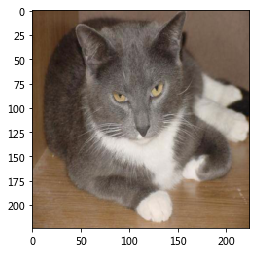

In [6]:
imshow(train[50][0])

In [7]:
#按批加在 Pytorch张量
train_data_gen = torch.utils.data.DataLoader(train,batch_size=64,num_workers=3)
valid_data_gen = torch.utils.data.DataLoader(valid,batch_size=64,num_workers=3)
dataset_sizes = {'train':len(train_data_gen.dataset),'valid':len(valid_data_gen.dataset)}
dataloaders = {'train':train_data_gen,'valid':valid_data_gen}

In [11]:
#构建网络架构
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

#if torch.cuda.is_available():
#    is_cuda = True
    
#if is_cuda:
#    model_ft=model_ft.cuda()

In [12]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# 训练模型
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.01,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每轮都有训练和验证阶段
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  #模型设为训练模式
            else:
                model.train(False)  #模型设为验证模式

            running_loss = 0.0
            running_corrects = 0

            #在数据上迭代
            for data in dataloaders[phase]:
                # 获取输入
                inputs, labels = data

                #封装成变量
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                #梯度参数清零
                optimizer.zero_grad()
                
                #前向
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                #只在训练阶段反向优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                #统计
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #深度复制模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #加载最优权重
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
